In [32]:
import re

def parse_log_file(file_path):
    log_entries = []
    pattern = (
        r"(?P<ip>\d{1,3}(?:\.\d{1,3}){3}) - - "
        r"\[(?P<datetime>[^\]]+)\] "
        r"\"(?P<method>[A-Z]+) (?P<endpoint>[^\s]+) HTTP/1.1\" "
        r"(?P<status>\d{3}) (?P<size>\d+)(?: \"(?P<message>[^\"]+)\")?"
    )

    with open(file_path, "r") as file:
        for line in file:
            match = re.match(pattern, line)
            if match:
                log_entries.append(match.groupdict())
    return log_entries


In [33]:
def most_frequent_endpoint(log_entries):
    endpoint_counter = Counter(entry['endpoint'] for entry in log_entries)
    most_common = endpoint_counter.most_common(1)
    return most_common[0] if most_common else ("None", 0)


In [34]:
def detect_suspicious_activity(log_entries, threshold=10):
    failed_attempts = Counter(
        entry['ip'] for entry in log_entries
        if entry['status'] == '401' or (entry.get('message') == 'Invalid credentials')
    )
    return [(ip, count) for ip, count in failed_attempts.items() if count > threshold
    ]


In [35]:
import csv

def save_to_csv(ip_requests, most_accessed, suspicious_activities, output_file):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Write Requests per IP
        writer.writerow(["Requests per IP"])
        writer.writerow(["IP Address", "Request Count"])
        writer.writerows(ip_requests)
        writer.writerow([])

        # Write Most Accessed Endpoint
        writer.writerow(["Most Accessed Endpoint"])
        writer.writerow(["Endpoint", "Access Count"])
        writer.writerow(most_accessed)
        writer.writerow([])

        # Write Suspicious Activity
        writer.writerow(["Suspicious Activity"])
        writer.writerow(["IP Address", "Failed Login Count"])
        writer.writerows(suspicious_activities)


In [36]:
# Step 1: Load the log file
log_file_path = '/content/sample.log'

# Step 2: Read and parse the log file
def read_log_file(file_path):
    with open(file_path, 'r') as file:
        return file.readlines()

# Step 3: Function to count requests per IP
def count_requests_per_ip(logs):
    ip_count = {}
    for line in logs:
        ip = line.split()[0]
        ip_count[ip] = ip_count.get(ip, 0) + 1
    return ip_count

def get_unique_endpoints(logs):
    endpoints = set()
    for line in logs:
        parts = line.split('"')
        if len(parts) > 1:
            endpoint = parts[1].split()[1]
            endpoints.add(endpoint)
    return endpoints

def count_response_codes(logs):
    response_codes = {}
    for line in logs:
        parts = line.split()
        if len(parts) > 8:
            code = parts[8]
            response_codes[code] = response_codes.get(code, 0) + 1
    return response_codes


logs = read_log_file(log_file_path)

requests_per_ip = count_requests_per_ip(logs)
unique_endpoints = get_unique_endpoints(logs)
response_code_counts = count_response_codes(logs)

print("Requests per IP:")
for ip, count in requests_per_ip.items():
    print(f"{ip}: {count}")

print("\nUnique Endpoints:")
for endpoint in unique_endpoints:
    print(endpoint)

print("\nResponse Code Counts:")
for code, count in response_code_counts.items():
    print(f"{code}: {count}")


Requests per IP:
192.168.1.1: 7
203.0.113.5: 8
10.0.0.2: 6
198.51.100.23: 8
192.168.1.100: 5

Unique Endpoints:
/login
/home
/dashboard
/profile
/feedback
/contact
/about
/register

Response Code Counts:
200: 21
401: 13


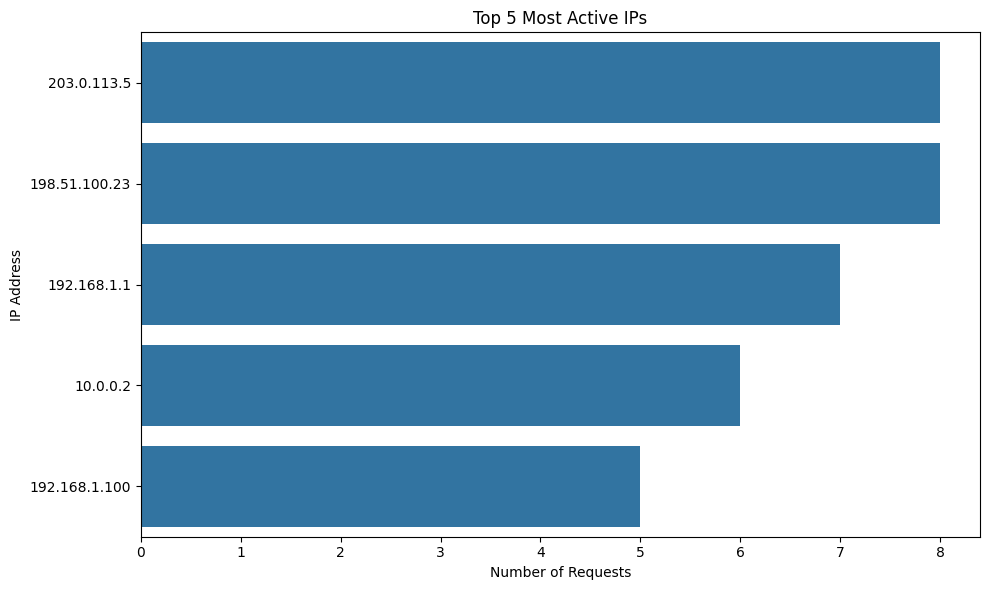

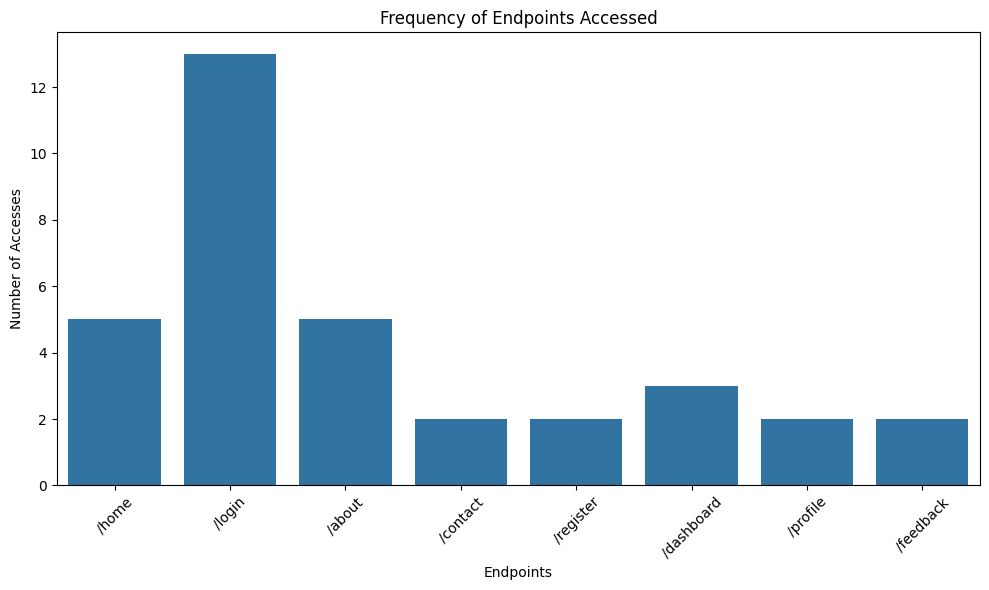

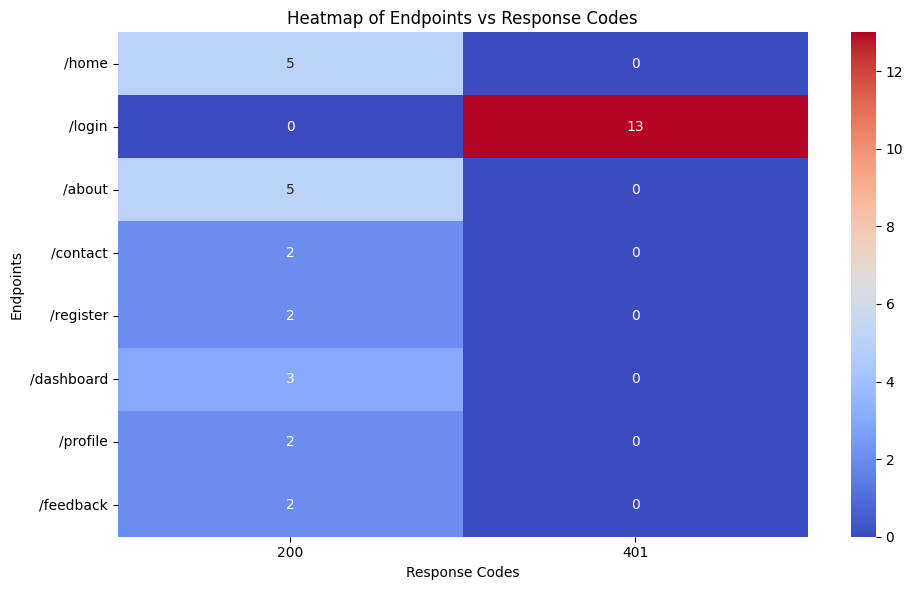

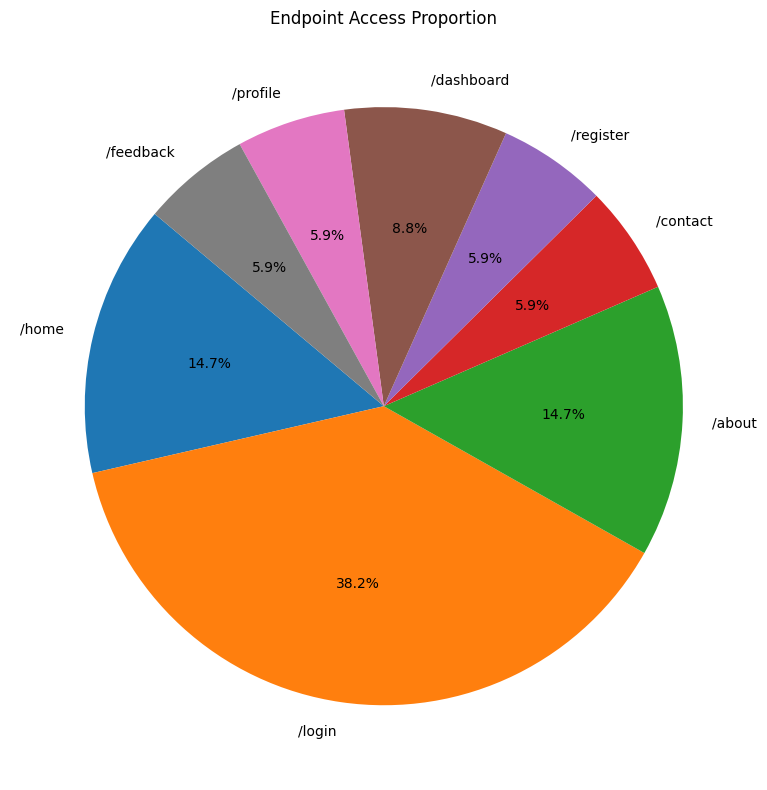

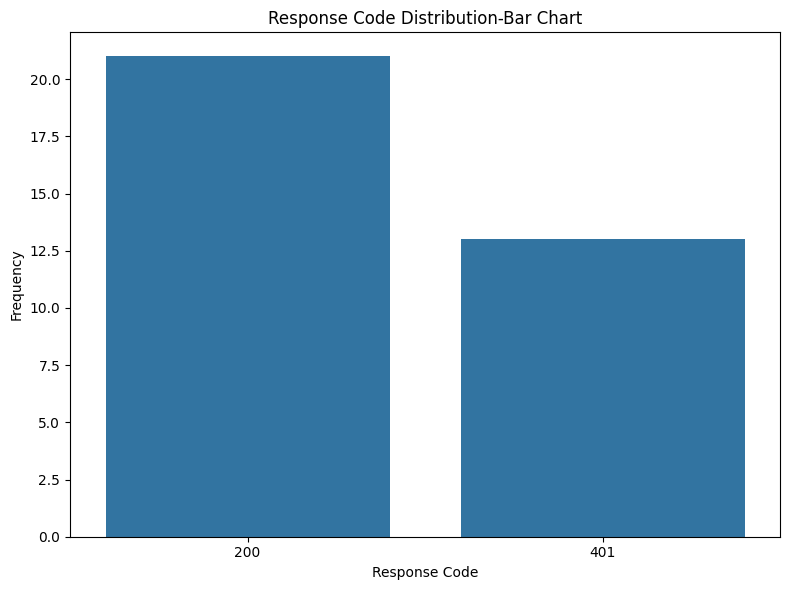

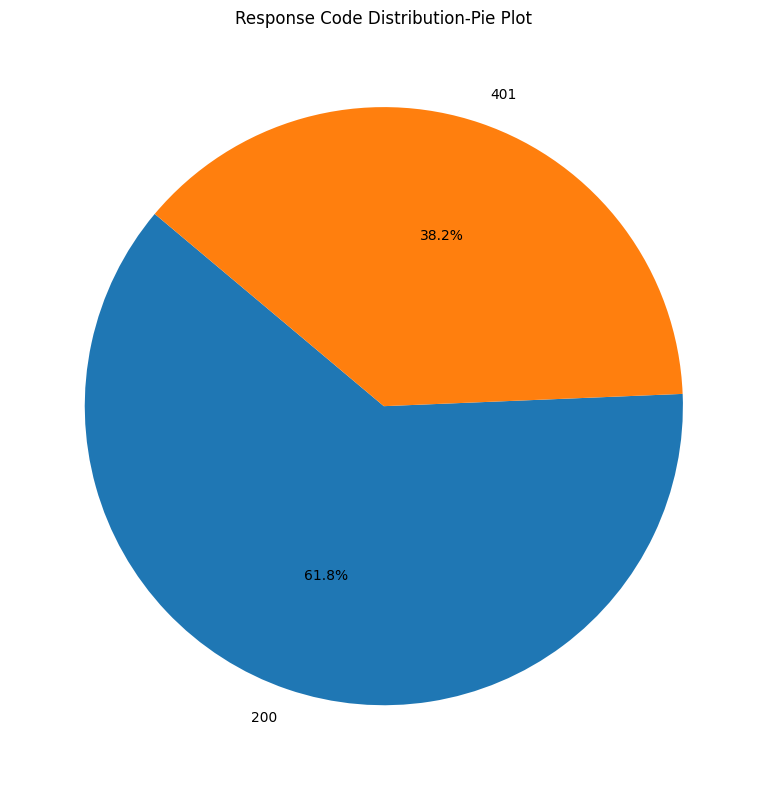

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from collections import Counter

log_file_path = '/content/sample.log'

def read_log_file(file_path):
    with open(file_path, 'r') as file:
        return file.readlines()

def parse_logs(logs):
    timestamps = []
    ips = []
    endpoints = []
    response_codes = []

    for line in logs:
        parts = line.split()
        if len(parts) < 9:
            continue

        # Extract IP
        ips.append(parts[0])

        # Extract endpoint
        endpoint_parts = line.split('"')
        if len(endpoint_parts) > 1:
            endpoints.append(endpoint_parts[1].split()[1])

        # Extract response code
        response_codes.append(parts[8])

    return timestamps, ips, endpoints, response_codes

# Analyze the logs
logs = read_log_file(log_file_path)
timestamps, ips, endpoints, response_codes = parse_logs(logs)

# Count data for analysis
requests_per_ip = Counter(ips)
endpoints_count = Counter(endpoints)
response_code_counts = Counter(response_codes)


# Visualizations

# Plot 1: Top 5 Most Active IPs
plt.figure(figsize=(10, 6))
top_ips = requests_per_ip.most_common(5)
sns.barplot(y=[ip[0] for ip in top_ips], x=[ip[1] for ip in top_ips], orient='h')
plt.title('Top 5 Most Active IPs')
plt.xlabel('Number of Requests')
plt.ylabel('IP Address')
plt.tight_layout()
plt.show()

# Plot 3: Frequency of Endpoints (Bar Plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=list(endpoints_count.keys()), y=list(endpoints_count.values()))
plt.title('Frequency of Endpoints Accessed')
plt.xlabel('Endpoints')
plt.ylabel('Number of Accesses')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot 4: Heatmap of Endpoints and Response Codes
plt.figure(figsize=(10, 6))
heatmap_data = Counter([(endpoint, code) for endpoint, code in zip(endpoints, response_codes)])
heatmap_matrix = {}
for (endpoint, code), count in heatmap_data.items():
    if endpoint not in heatmap_matrix:
        heatmap_matrix[endpoint] = {}
    heatmap_matrix[endpoint][code] = count

# Fill missing data in heatmap
endpoints_set = list(endpoints_count.keys())
codes_set = list(response_code_counts.keys())
heatmap_filled = [[heatmap_matrix.get(endpoint, {}).get(code, 0) for code in codes_set] for endpoint in endpoints_set]

sns.heatmap(heatmap_filled, annot=True, fmt='d', xticklabels=codes_set, yticklabels=endpoints_set, cmap='coolwarm')
plt.title('Heatmap of Endpoints vs Response Codes')
plt.xlabel('Response Codes')
plt.ylabel('Endpoints')
plt.tight_layout()
plt.show()

# Plot 5: Endpoint Access Proportion (Pie Chart)
plt.figure(figsize=(8, 8))
plt.pie(endpoints_count.values(), labels=endpoints_count.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Endpoint Access Proportion')
plt.tight_layout()
plt.show()

# Plot 6: Response Code Distribution (Bar Plot)
plt.figure(figsize=(8, 6))
sns.barplot(x=list(response_code_counts.keys()), y=list(response_code_counts.values()))
plt.title('Response Code Distribution-Bar Chart')
plt.xlabel('Response Code')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 8))
plt.pie(response_code_counts.values(), labels=response_code_counts.keys(), autopct='%1.1f%%', startangle=140)
plt.title('Response Code Distribution-Pie Plot')
plt.tight_layout()
plt.show()


# Save analysis results
def save_results_to_csv(output_file, requests_per_ip, endpoints_count, response_code_counts):
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)

        # Requests per IP
        writer.writerow(["Requests per IP"])
        writer.writerow(["IP Address", "Request Count"])
        for ip, count in requests_per_ip.items():
            writer.writerow([ip, count])
        writer.writerow([])

        # Most Accessed Endpoint
        writer.writerow(["Most Accessed Endpoint"])
        writer.writerow(["Endpoint", "Access Count"])
        most_accessed = endpoints_count.most_common(1)
        if most_accessed:
            writer.writerow([most_accessed[0][0], most_accessed[0][1]])
        else:
            writer.writerow(["None", 0])
        writer.writerow([])

        # Suspicious Activity (Example: Status Code 401)
        writer.writerow(["Suspicious Activity"])
        writer.writerow(["IP Address", "Failed Login Count"])
        failed_attempts = Counter(ip for ip, code in zip(ips, response_codes) if code == '401')
        for ip, count in failed_attempts.items():
            writer.writerow([ip, count])

# Save analysis results
output_file = '/content/log_analysis_results.csv'
save_results_to_csv(output_file, requests_per_ip, endpoints_count, response_code_counts)

